In [103]:
!pip install transformers datasets seqeval

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
import json
import numpy as np
from datasets import Dataset, Features, Sequence, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from seqeval.metrics import classification_report

In [106]:
import glob
import os

###  1. Prepare Data

In [107]:
RAW_CLASSES = ['SKILL_HARD', 'SKILL_SOFT', 'ENGLISH_LEVEL', 'DEGREE', 'EXPERIENCE_LEVEL',
               'EXPERIENCE_YEARS', 'BENEFIT', 'LOCATION', 'COMPANY_NAME', 'ROLE']
ALL_LABELS = ["O"] + [f"{prefix}-{name}" for name in RAW_CLASSES for prefix in ["B", "I"]]
NUM_LABELS = len(ALL_LABELS)

label_to_id = {label: i for i, label in enumerate(ALL_LABELS)}
id_to_label = {i: label for i, label in enumerate(ALL_LABELS)}

In [108]:
def get_json_ann(json_path: str):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data["text"], data["entities"]

In [138]:
def tokenize_and_align_labels(text: str, entities):
    """
    Tokenizes the input text and aligns the NER labels with the tokens.
    Args:
        text (str): The input text to be tokenized.
        entities (_type_): _list of tuples (start_char, end_char, entity_type)_

    Returns:
        tuple: tokens, ner_tags, succ
    """
    tokens = []
    token_starts = []

    # Simple whitespace tokenizer
    current_pos = 0
    for char_idx, char in enumerate(text):
        if char.isspace():
            if current_pos < char_idx:
                token = text[current_pos:char_idx]
                tokens.append(token)
                token_starts.append(current_pos)
            current_pos = char_idx + 1

    # Add the last token if any
    if current_pos < len(text):
        token = text[current_pos:]
        tokens.append(token)
        token_starts.append(current_pos)

    # Calculate token ends
    token_ends = []
    for i, token in enumerate(tokens):
        token_ends.append(token_starts[i] + len(token))

    ner_tags = [label_to_id['O']] * len(tokens)

    succ = 0 # count of successfully labeled tokens
    for start_char, end_char, entity_type in entities:
        entity_label = entity_type
        for token_idx in range(len(tokens)):
            token_start = token_starts[token_idx]
            token_end = token_ends[token_idx]
            if token_start < end_char and token_end > start_char:
                if token_start >= start_char and (token_idx == 0 or token_starts[token_idx - 1] < start_char):
                    ner_tags[token_idx] = label_to_id[f'B-{entity_label}']
                    succ += 1
                else:
                    ner_tags[token_idx] = label_to_id[f'I-{entity_label}']
                    succ += 1
    return tokens, ner_tags, succ

In [139]:
def load_ukrainian_ner_dataset(data_dir):
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    dataset_items = []
    succ_dict = {}
    for json_path in json_files:
        text, entities = get_json_ann(json_path)
        tokens, ner_tags, succ = tokenize_and_align_labels(text, entities)
        succ_dict[json_path] = succ
        item = {
            "tokens": tokens,
            "ner_tags": ner_tags
        }
        dataset_items.append(item)
    return dataset_items, succ_dict

In [111]:
folders = os.listdir("/content/drive/MyDrive/Data/cleaned_standard_annotated/")
folders

['Python',
 'DevOps',
 'Java',
 'PHP',
 'Android',
 'dotNET',
 'FrontEnd',
 'Golang',
 'ML',
 'macOS',
 'Node']

In [141]:
my_dataset = []
for folder in folders:
  print("Loading:", folder)
  dataset, succ_log = load_ukrainian_ner_dataset(f"/content/drive/MyDrive/Data/cleaned_standard_annotated/{folder}")
  my_dataset.extend(dataset)

Loading: Python
Loading: DevOps
Loading: Java
Loading: PHP
Loading: Android
Loading: dotNET
Loading: FrontEnd
Loading: Golang
Loading: ML
Loading: macOS
Loading: Node


In [142]:
features = Features({
    'tokens': Sequence(Value('string')),
    'ner_tags': Sequence(ClassLabel(names=ALL_LABELS)),
})

raw_dataset = Dataset.from_list(my_dataset, features=features)
train_test_split = raw_dataset.train_test_split(test_size=0.2, seed=42)
tokenized_datasets = train_test_split

In [143]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 561
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 141
    })
})

In [144]:
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [145]:
def tokenize_and_align_labels(examples):
    # This function is designed to handle long documents by splitting them into
    # multiple sub-sequences using return_overflowing_tokens and a stride.

    # 1. Tokenize the inputs and allow overflow
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        # Key arguments for handling long sequences:
        return_overflowing_tokens=True,
        stride=128 # 128 tokens of overlap to maintain context continuity
    )

    # Get the mapping from the new sub-sequences back to the original example index
    overflow_mapping = tokenized_inputs.pop("overflow_to_sample_mapping")
    all_labels = []

    # 2. Iterate through all generated sub-sequences
    for i in range(len(tokenized_inputs["input_ids"])):
        original_idx = overflow_mapping[i]
        original_labels = examples["ner_tags"][original_idx]
        word_ids = tokenized_inputs.word_ids(batch_index=i)

        previous_word_idx = None
        label_ids = []

        # 3. Align the labels
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens ([CLS], [SEP], padding) get an ignored label
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # Start of a new word, assign the original label
                label_ids.append(original_labels[word_idx])
            else:
                # Inside a word (subword token), assign the same label as the first token
                label_ids.append(original_labels[word_idx])

            previous_word_idx = word_idx

        all_labels.append(label_ids)

    # 4. Finalize the output structure for the Trainer
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

# Apply the tokenization and alignment
# Since one original example can turn into multiple tokenized examples, we
# need to remove the columns that don't match the new, larger length (like 'tokens' and 'ner_tags').
tokenized_datasets = train_test_split.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_test_split["train"].column_names
)

Map:   0%|          | 0/561 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

### 2. Define Model

In [146]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=NUM_LABELS,
    id2label=id_to_label,
    label2id=label_to_id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3. Evaluate Function

In [147]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    report = classification_report(true_labels, true_predictions, output_dict=True)

    return {
        "precision": report["micro avg"]["precision"],
        "recall": report["micro avg"]["recall"],
        "f1": report["micro avg"]["f1-score"]
    }

### 4. Train

In [148]:
from transformers import EarlyStoppingCallback
from transformers import TrainerCallback

In [149]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class LivePlotCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        if "loss" in logs:
            self.train_losses.append(logs["loss"])
        if "eval_loss" in logs:
            self.eval_losses.append(logs["eval_loss"])

        clear_output(wait=True)
        plt.figure(figsize=(8,5))
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.eval_losses, label="Eval Loss")
        plt.xlabel("Logging Step")
        plt.ylabel("Loss")
        plt.title("Real-Time Loss Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

In [150]:
training_args = TrainingArguments(
    output_dir="./ustym_ner_0",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=20,
    report_to="none",

    metric_for_best_model="eval_loss",
    greater_is_better=False
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2),
        LivePlotCallback()
    ]
)

/tmp/ipython-input-804930927.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


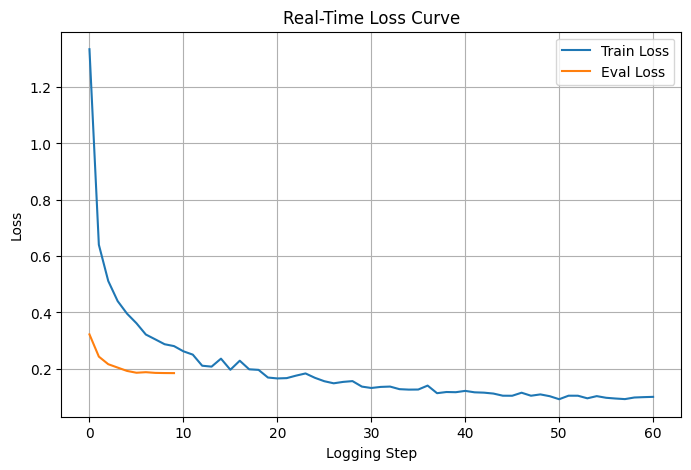

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.361800,0.322149,0.659122,0.686792,0.672673
2,0.250300,0.243247,0.730769,0.739387,0.735053
3,0.198200,0.216294,0.763584,0.771148,0.767347
4,0.183500,0.204316,0.756479,0.814701,0.784511
5,0.136800,0.192443,0.802561,0.803066,0.802814
6,0.126400,0.185989,0.793553,0.822563,0.807798
7,0.115300,0.187975,0.790087,0.832075,0.810538
8,0.109100,0.185499,0.802204,0.829953,0.815842
9,0.103000,0.184915,0.801358,0.835063,0.817863
10,0.100400,0.184664,0.805218,0.832311,0.818540


TrainOutput(global_step=1230, training_loss=0.19762318163383297, metrics={'train_runtime': 1578.0642, 'train_samples_per_second': 6.229, 'train_steps_per_second': 0.779, 'total_flos': 2566723037002668.0, 'train_loss': 0.19762318163383297, 'epoch': 10.0})

In [151]:
trainer.train()

In [153]:
trainer.save_model("./ustym_ner_0_final")
tokenizer.save_pretrained("./ustym_ner_0_final")

('./ustym_ner_0_final/tokenizer_config.json',
 './ustym_ner_0_final/special_tokens_map.json',
 './ustym_ner_0_final/vocab.txt',
 './ustym_ner_0_final/added_tokens.json',
 './ustym_ner_0_final/tokenizer.json')

### 5. Testing

In [121]:
from transformers import pipeline

In [154]:
model_checkpoint = "/content/ustym_ner_0_final"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint
)

Device set to use cuda:0


In [159]:
with open("/content/drive/MyDrive/Data/cleaned_standard_annotated/Java/11.json") as f:
  text = json.load(f)["text"]

In [160]:
result = token_classifier(text)

In [161]:
COLORS = [
    "\033[91m", "\033[92m", "\033[93m", "\033[94m",
    "\033[95m", "\033[96m", "\033[31m", "\033[32m",
    "\033[33m", "\033[34m", "\033[35m", "\033[36m"
]
RESET = "\033[0m"


def merge_bio_annotations(text, bio_annotations):
    """
    Convert token-level BIO annotations (start, end, label=B-XXX/I-XXX)
    into merged entity spans (start, end, label=XXX).
    """

    merged = []
    current = None

    # Sort by start index
    bio_annotations = sorted(bio_annotations, key=lambda x: x["start"])

    for ann in bio_annotations:
        raw_label = ann["entity"]
        if raw_label == "O":
            # Close current if open
            if current:
                merged.append(current)
                current = None
            continue

        # Extract main label
        prefix, cls = raw_label.split("-", 1)

        if prefix == "B":
            # Start new entity
            if current:
                merged.append(current)
            current = {"start": ann["start"], "end": ann["end"], "label": cls}

        elif prefix == "I":
            # Continue same entity
            if current and current["label"] == cls:
                current["end"] = ann["end"]
            else:
                # Malformed BIO → treat as new entity
                current = {"start": ann["start"], "end": ann["end"], "label": cls}

    # Close last entity
    if current:
        merged.append(current)

    return merged


def colorize(text, entities):
    """Apply ANSI colors to merged entities."""
    label_colors = {lbl: COLORS[i % len(COLORS)] for i, lbl in enumerate(RAW_CLASSES)}

    out = text
    # Replace from end → avoids shifting indices
    for ent in sorted(entities, key=lambda x: x["start"], reverse=True):
        color = label_colors.get(ent["label"], RESET)
        out = (
            out[:ent["start"]]
            + color
            + out[ent["start"]:ent["end"]]
            + RESET
            + out[ent["end"]:]
        )

    return out, label_colors


def print_legend(label_colors):
    print("\nLegend:")
    for lbl, col in label_colors.items():
        print(f"{col}{lbl}{RESET}")

In [162]:
merged = merge_bio_annotations(text, result)
colored_text, colors = colorize(text, merged)

print(colored_text)
print_legend(colors)

Senior Java Engineer (with DevOps skills) (#4020)
We are looking for a highly skilled and enthusiastic Senior Java Engineer
(with DevOps skills) to become an integral part of our dynamic team in
Kyiv.

This role offers an exciting opportunity to work on cutting-edge projects
involving the integration of third-party hardware, the development of
sophisticated in-system customisations, and the creation of robust Java web
applications with intuitive front-end interfaces. Beyond development, you will
also play a key role in designing, implementing, and supporting Docker setups
across various environments and building essential emulators for endpoint
devices.

Responsibilities:

Design, develop, and maintain high-performance Java applications for seamless integration with diverse third-party hardware systems.
Implement tailored in-system customisations to meet specific client requirements and enhance application functionality.
Build and enhance Java web applications, encompassing both back-e